In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve
)


In [ ]:
# 1. Generate synthetic dataset
def generate_data(n_samples=1000, seed=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        n_classes=2,
        weights=[0.7, 0.3],
        flip_y=0.01,
        random_state=seed
    )
    df = pd.DataFrame(X, columns=[f"num_{i}" for i in range(X.shape[1])])
    df["cat_1"] = np.random.choice(["A", "B", "C"], size=n_samples)
    df["cat_2"] = np.random.choice(["X", "Y"], size=n_samples)
    df["target"] = y
    return df

df = generate_data()

In [ ]:
# 2. Train/val/test split
train_val, test = train_test_split(df, test_size=0.2, stratify=df["target"], random_state=42)
train, val = train_test_split(train_val, test_size=0.1, stratify=train_val["target"], random_state=42)

In [ ]:
# 3. Define preprocessing pipeline
num_features = [col for col in df.columns if col.startswith("num_")]
cat_features = ["cat_1", "cat_2"]

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

In [ ]:
# 4. Define model pipelines
models = {
    "logreg": LogisticRegression(solver="liblinear", class_weight="balanced", random_state=42),
    "rf": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "gbdt": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

param_grids = {
    "logreg": {"model__C": [0.01, 0.1, 1.0]},
    "rf": {"model__max_depth": [None, 5, 10]},
    "gbdt": {"model__learning_rate": [0.01, 0.1]}
}

X_train = train[num_features + cat_features]
y_train = train["target"]
X_val = val[num_features + cat_features]
y_val = val["target"]
X_test = test[num_features + cat_features]
y_test = test["target"]

best_models = {}
val_scores = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(pipe, param_grids[name], scoring="f1_macro", cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    val_pred = grid.predict(X_val)
    val_score = f1_score(y_val, val_pred, average="macro")
    val_scores[name] = val_score

In [ ]:
# 5. Choose best model
best_model_name = max(val_scores, key=val_scores.get)
final_model = best_models[best_model_name]
print(f"Best model: {best_model_name} (F1-macro on val: {val_scores[best_model_name]:.4f})")

Best model: rf (F1-macro on val: 0.9548)


In [ ]:
# 6. Evaluate on test set
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision_macro": precision_score(y_test, y_pred, average="macro"),
    "recall_macro": recall_score(y_test, y_pred, average="macro"),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "pr_auc": average_precision_score(y_test, y_proba)
}

print("Test Metrics:")
print(json.dumps(metrics, indent=2))

Test Metrics:
{
  "accuracy": 0.92,
  "precision_macro": 0.9087630724846736,
  "recall_macro": 0.9010496520816134,
  "f1_macro": 0.9047619047619048,
  "roc_auc": 0.9729920981247788,
  "pr_auc": 0.9472003200179928
}


In [ ]:
# 7. Plots
os.makedirs("figures", exist_ok=True)

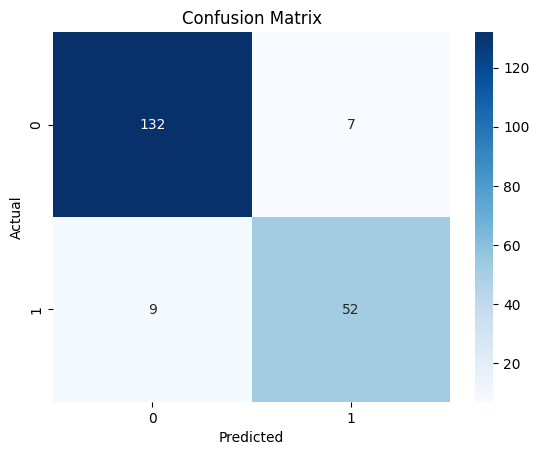

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("figures/confusion_matrix.png")
plt.show()

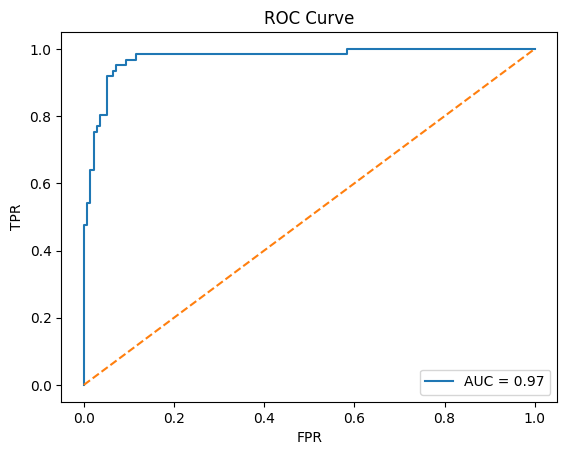

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.2f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.savefig("figures/roc_curve.png")
plt.show()

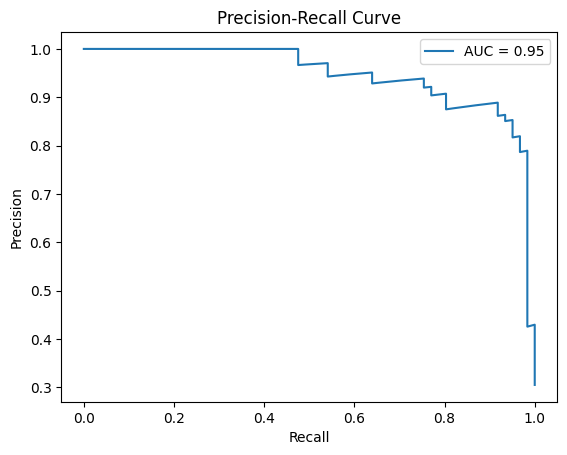

In [ ]:
# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f"AUC = {metrics['pr_auc']:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("figures/pr_curve.png")
plt.show()


Core Methodological Themes in AutoCLAIM:

Imbalanced Classification Handling

Scikit-learn Pipelines and Model Tuning

Model Comparison using Cross-Validation

Evaluation with F1-Macro and ROC-AUC

Automated and Reproducible ML Workflows

🔬 Key Academic References
1. Class Imbalance and Evaluation Metrics

He, H., & Garcia, E. A. (2009).
"Learning from Imbalanced Data"
IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284.
📌 Relevance: Reviews strategies for handling imbalanced datasets (like class weighting, undersampling), and promotes the use of F1-score and ROC-AUC over accuracy.
🔗 https://doi.org/10.1109/TKDE.2008.239

2. Robust Model Evaluation

Forman, G., & Scholz, M. (2010).
"Apples-to-apples in cross-validation studies: pitfalls in classifier performance measurement"
ACM SIGKDD Explorations Newsletter, 12(1), 49–57.
📌 Relevance: Stresses correct use of StratifiedKFold and consistent metrics like F1-macro for fair model comparisons.
🔗 https://doi.org/10.1145/1882471.1882479

3. Automated ML Workflows & Reproducibility

Van der Walt, S., Colbert, S. C., & Varoquaux, G. (2011).
"The NumPy Array: A Structure for Efficient Numerical Computation"
Computing in Science & Engineering, 13(2), 22–30.
📌 Relevance: Justifies the use of tools like NumPy, pandas, and modular CLI pipelines for reproducible, performant machine learning workflows.
🔗 https://doi.org/10.1109/MCSE.2011.37

4. Gradient Boosting & Tree Ensembles

Friedman, J. H. (2001).
"Greedy Function Approximation: A Gradient Boosting Machine"
Annals of Statistics, 29(5), 1189–1232.
📌 Relevance: Foundational paper on Gradient Boosting, explaining why it's effective even with limited preprocessing, especially on tabular data.
🔗 https://projecteuclid.org/euclid.aos/1013203451

✅ Summary Statement

AutoCLAIM is aligned with best practices from academic research on imbalanced classification, particularly the use of F1-macro, class-weighted models, and stratified cross-validation for robust comparison — as emphasized by He & Garcia (2009) and Forman & Scholz (2010). Its use of modular pipelines and reproducibility mechanisms reflects modern standards in ML engineering.